
<a href="http://cardiff.ac.uk" style="float:left">
    <img
      title="Cardiff University Logo"
      src="https://upload.wikimedia.org/wikipedia/en/b/b1/Cardiff_university_logo.png"
      />
</a>

# Media Monitor Analysis

A joint research project between the [School of Computer Science](https://www.cs.cf.ac.uk/) and the [School of Journalism](http://www.cardiff.ac.uk/journalism-media-cultural-studies) at Cardiff University. 

---

*This notebook requires a mongoDB database called **`media-monitor`** with a **`tweets`** collection containing [Tweet objects](https://dev.twitter.com/overview/api/tweets). It aims to analyse the data collected by the [media-monitor](https://github.com/taylorrees/media-monitor) tool.*

## Table of Contents

- [1. Key Terms](#1.-Key-Terms)


- [2. Getting Started](#2.-Getting-Started)


- [3. Analysis](#3.-Analysis)
    - [3.1. Original Tweets](#3.1.-Original-Tweets)
    - [3.2. Retweets](#3.2.-Retweets)
    - [3.3. Replies](#3.3.-Replies)
    - [3.4. Links](#3.4.-Links)
    - [3.5. Hashtags](#3.5.-Hashtags)
    
    
- [4. Networks](#4.-Networks)
    - [4.1. Mentions](#4.1.-Mentions)
    - [4.2. Replies](#4.2.-Replies)

---

## 1. Key Terms

**`JOI`** Journalists of interest

**`OOI`** Organisations of interest

**`EXT`** Accounts not followed by streaming api

## 2. Getting Started

To get started import the dependencies. 

*We also need to extend the `Collect` class to cater to our needs as we want the store method to clear a specified collection everytime it is called.*

In [1]:
"""Import dependencies"""

from db import DB
from collections import Counter
from IPython.display import display
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Next, setup new collections in the database.

_**Note**_

Only call if the journalists and organisations collections are not already setup in the database. This will read the JSON files containing journalist and organisation twitter lists and store them in the appropriate database.

In [ ]:
"""Setup for collection creation"""

from collect import Collect
from json import load

class Collect(Collect):
    def store(self, collection):
        # extend and alter store
        DB[collection].delete_many({})
        DB[collection].insert_many(self.members)

In [ ]:
"""Create database collections"""

# get & store journalists from twitter lists
j = load(open("journalists.json"))
collect = Collect(lists=j)
collect.store("journalists")

# get & store news organisations from twitter lists
o = load(open("organisations.json"))
collect = Collect(lists=o, refine=False, append=True)
collect.store("organisations")

## 3. Analysis

*A collection of inline visualisations to illustrate the demographics of the data collected.*

In [2]:
"""Setup for analysis"""

def pie(sizes, labels):
    """Plot a pie chart"""
    
    colors = ['lightskyblue', 'lightcoral']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

    plt.axis('equal')
    plt.show()
    
    
def bar(x, y, xticks, ylabel):
    """Plot a bar chart"""
    
    display(Markdown("**Top 10**"))
    plt.bar(x, y, alpha=0.5)
    plt.xticks(x, labels, rotation='45')
    plt.ylabel(ylabel)
    plt.show()

### 3.1. Original Tweets

This section of the analysis aims to look at the number of original tweets authored throughout the data collection period. An original tweet is one that has been published by a user that is not a reply nor a retweet. We will look for tweets authored by the `JOI`, `OOI` and `EXT` accounts. 

In [3]:
"""Collect the data"""

# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
})

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "in_reply_to_status_id_str": {"$eq": None},
    "retweeted_status": {"$exists": False}
})

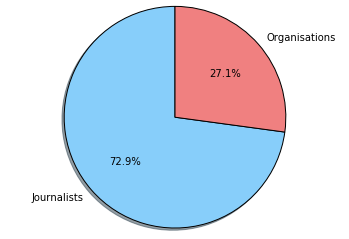

In [4]:
"""Plot a pie chart"""

# calculate mean percentage
total = joi.count() + ooi.count()
joi_size = (joi.count() / total) * 100
ooi_size = (ooi.count() / total) * 100

# data to plot
sizes = [joi_size, ooi_size]
labels = "Journalists", "Organisations"

# plot
pie(sizes, labels)

**Top 10**

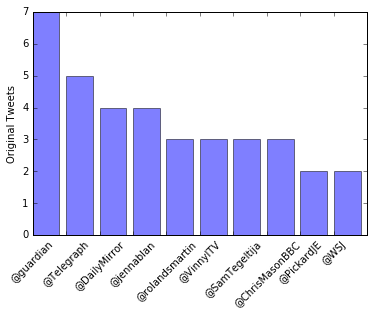

In [5]:
"""Plot top 10"""

counter = {j:0 for j in journalists + organisations}

# create list of users
id_strs = ["@%s" % tweet["user"]["screen_name"] for tweet in joi.clone()]
id_strs += ["@%s" % tweet["user"]["screen_name"] for tweet in ooi.clone()]

# count occurances
counter = Counter(id_strs)
most_common = counter.most_common(10)

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
bar(x, y, xticks=labels, ylabel="Original Tweets")

### 3.2. Retweets

This section of the analysis aims to look at the number of retweets created throughout the data collection period. 

In [6]:
"""Collect the data"""

# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "retweeted_status": {"$exists": True}
})

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "retweeted_status": {"$exists": True}
})

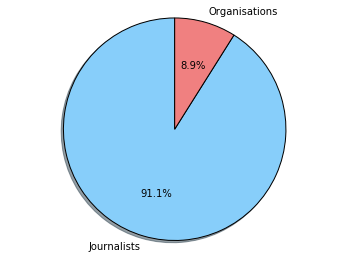

In [7]:
"""Plot a pie chart"""

# calculate mean percentage
total = joi.count() + ooi.count()
joi_size = (joi.count() / total) * 100
ooi_size = (ooi.count() / total) * 100

# data to plot
sizes = [joi_size, ooi_size]
labels = "Journalists", "Organisations"

# plot
pie(sizes, labels)

**Top 10**

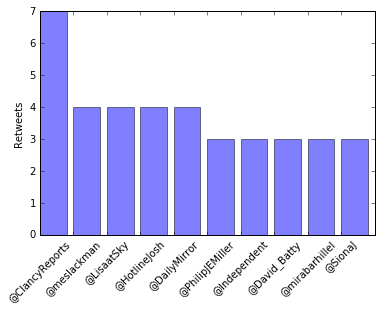

In [8]:
"""Plot top 10"""

counter = {j:0 for j in journalists + organisations}

# create list of users
id_strs = ["@%s" % tweet["user"]["screen_name"] for tweet in joi.clone()]
id_strs += ["@%s" % tweet["user"]["screen_name"] for tweet in ooi.clone()]

# count occurances
counter = Counter(id_strs)
most_common = counter.most_common(10)

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
bar(x, y, xticks=labels, ylabel="Retweets")

### 3.3. Replies

This section of the analysis aims to look at the number of replies authored throughout the data collection period. 

In [9]:
"""Collect the data"""

# get sets of id_str's
journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

joi = DB.tweets.find({
    "user.id_str": {"$in": journalists},
    "in_reply_to_status_id_str": {"$ne": None}
})

ooi = DB.tweets.find({
    "user.id_str": {"$in": organisations},
    "in_reply_to_status_id_str": {"$ne": None}
})

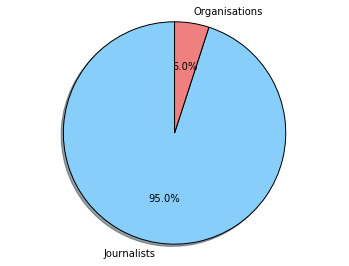

In [10]:
"""Plot a pie chart"""

# calculate mean percentage
total = joi.count() + ooi.count()
joi_size = (joi.count() / total) * 100
ooi_size = (ooi.count() / total) * 100

# data to plot
sizes = [joi_size, ooi_size]
labels = "Journalists", "Organisations"

# plot
pie(sizes, labels)

**Top 10**

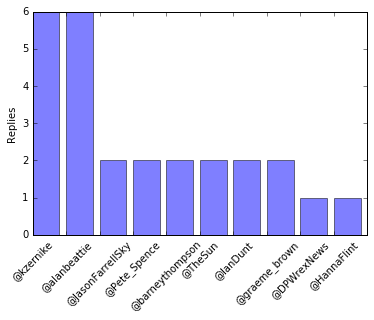

In [11]:
"""Plot top 10"""

counter = {j:0 for j in journalists + organisations}

# create list of users
id_strs = ["@%s" % tweet["user"]["screen_name"] for tweet in joi.clone()]
id_strs += ["@%s" % tweet["user"]["screen_name"] for tweet in ooi.clone()]

# count occurances
counter = Counter(id_strs)
most_common = counter.most_common(10)

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
bar(x, y, xticks=labels, ylabel="Replies")

### 3.4. Links

This section of the analysis aims to look at the number of links included in the body of the tweets collected throughout the data collection period. 

In [11]:
"""Collect the data"""

tweets = [t for t in DB.tweets.find()]
urls = [h["expanded_url"] for t in tweets for h in t["entities"]["urls"]]

In [12]:
"""Display top 10"""

most_common = Counter(urls).most_common(10)
most_common = [(key, value) for (key, value) in most_common]

# data to output 
table = " | URL | Occurances | \n"
table += "| --- | ---------- | \n"

for url, occ in most_common:
    # truncate long urls
    truncated = (url[:30] + "...") if len(url) > 25 else url
    table += "| [%s](%s) | %s | \n" % (truncated, url, occ)
    
# output
display(Markdown("**Top 10**"))
display(Markdown(table))

**Top 10**

 | URL | Occurances | 
| --- | ---------- | 
| [http://bbc.co.uk/chilcot](http://bbc.co.uk/chilcot) | 586 | 
| [http://snpy.tv/29w8hdD](http://snpy.tv/29w8hdD) | 173 | 
| [http://bbc.in/29lj1LX](http://bbc.in/29lj1LX) | 146 | 
| [http://cnn.it/29gUodd](http://cnn.it/29gUodd) | 70 | 
| [http://reut.rs/29lj4HT](http://reut.rs/29lj4HT) | 60 | 
| [http://www.telegraph.co.uk/new...](http://www.telegraph.co.uk/news/2016/07/06/chilcot-inquiry-judgement-day-for-tony-blair-as-iraq-war-report/) | 58 | 
| [http://bbc.in/29l5lRm](http://bbc.in/29l5lRm) | 45 | 
| [http://snpy.tv/29hfPeJ](http://snpy.tv/29hfPeJ) | 44 | 
| [http://ind.pn/29nxzqs](http://ind.pn/29nxzqs) | 42 | 
| [http://nyti.ms/29w2dli](http://nyti.ms/29w2dli) | 40 | 


In [13]:
"""Display an overview"""

# data to output
table = " | Links | Unique | \n"
table += "| ----- | ------ | \n"
table += "| %s | %s | \n" % (len(urls), len(set(urls)))

# output
display(Markdown(table))

 | Links | Unique | 
| ----- | ------ | 
| 3195 | 657 | 


### 3.5. Hashtags

This section of the analysis aims to look at the number of hashtags included in the body of the tweets collected throughout the data collection period. 

In [13]:
"""Collect the data"""

tweets = [t for t in DB.tweets.find()]
hashtags = [h["text"] for t in tweets for h in t["entities"]["hashtags"]]

**Top 10**

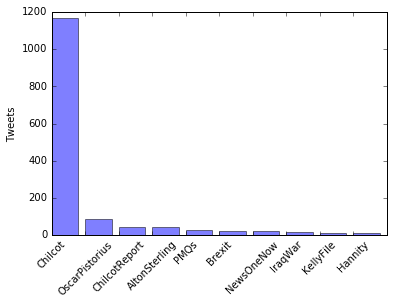

In [14]:
"""Plot top 10"""

most_common = Counter(hashtags).most_common(10)
most_common = [(key, value) for (key, value) in most_common]

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
bar(x, y, xticks=labels, ylabel="Tweets")

In [16]:
"""Display an overview"""

# data to output
table = " | Hashtags | Unique | \n"
table += "| -------- | ------ | \n"
table += "| %s | %s | \n" % (len(hashtags), len(set(hashtags)))

display(Markdown(table))

 | Hashtags | Unique | 
| -------- | ------ | 
| 1735 | 167 | 


## 4. Networks

*A collection of computed datasets to create network visualisations using an external graphing tool such as [Gephi](https://gephi.org).*

In [17]:
"""Setup for networks"""

from pymongo import MongoClient
from csv import writer
from time import time

# specify output folder
output_folder = "./analysis"

### 4.1. Mentions

This section aims to generate a collection of nodes and associated edges from a twitter mentions dataset. 

In [18]:
"""Collect the data"""

start = time()

tweets = [tweet 
          for tweet in DB.tweets.find()]

# find all edges
edges = [(tweet["user"]["screen_name"], mention["screen_name"])
         for tweet in tweets[:]
             for mention in tweet["entities"]["user_mentions"]]

# generate nodes from edges
nodes = {node 
         for edge in edges 
             for node in edge}

print("Runtime: %.3fs" % (time() - start))

Runtime: 0.870s


In [19]:
"""Write nodes to CSV"""

node_file = "%s/mention_nodes.csv" % (output_folder)

# convert into csv format
nodes = [[node, node] 
         for node in nodes]

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [20]:
"""Write edges to CSV"""

edge_file = "%s/mention_edges.csv" % (output_folder)

# convert into csv format
edges = [[nodes[0], nodes[1], weight] 
         for nodes, weight in Counter(edges).items()]

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target", "weight"])
    w.writerows(edges)

### 4.2. Replies

This section aims to generate a collection of nodes and associated edges from a twitter replies dataset. 

In [21]:
"""Collect the data"""

start = time()

tweets = [t for t in DB.tweets.find()]
nodes = set()
edges = set()

# collect nodes
for tweet in tweets:
    source = tweet["user"]["id_str"]
    target = tweet["in_reply_to_user_id_str"]

    if target is not None:
        nodes.add((source, source))
        nodes.add((target, target))
        edges.add((source, target))
        
print("Runtime: %.3fs" % (time() - start))

Runtime: 0.741s


In [22]:
"""Write nodes to CSV"""

node_file = "%s/reply_nodes.csv" % (output_folder)

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [23]:
"""Write edges to CSV"""

edge_file = "%s/reply_edges.csv" % (output_folder)

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target"])
    w.writerows(edges)